# Installation

## Downloading data

In [8]:
#@title Input here link to the splitted_dataset.zip
data_link = "https://drive.google.com/file/d/13TvqLqCHwDNVK2kBZyHhVPQ80LZ_oA2s" # @param {type:"string"}
data_link = data_link.split('/')[-1]

In [9]:
!gdown { data_link }

Downloading...
From (original): https://drive.google.com/uc?id=13TvqLqCHwDNVK2kBZyHhVPQ80LZ_oA2s
From (redirected): https://drive.google.com/uc?id=13TvqLqCHwDNVK2kBZyHhVPQ80LZ_oA2s&confirm=t&uuid=fec9ec57-b00e-4dae-a941-a3b0c127b724
To: /content/splitted_dataset_v2.zip
100% 113M/113M [00:00<00:00, 131MB/s] 


In [17]:
!mkdir data

In [ ]:
!unzip /content/splitted_dataset_v2.zip -d /content/data/

## Install YOLO library

In [ ]:
!pip install ultralytics

## Imports

In [11]:
from google.colab.patches import cv2_imshow
import yaml
import os
import cv2
import random
import hashlib
import shutil
from ultralytics import YOLO

random.seed(int(hashlib.sha512("бубибу".encode("utf-8")).hexdigest(), 16))

# Train YOLO model

In [ ]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 51.4MB/s]


In [ ]:
model.train(data="data.yaml", epochs=30)

Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify

In the end we get further metrics:

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)
                   all        103        801      0.879      0.864       0.91      0.553
               glasses        103         23      0.672      0.534      0.776      0.341
            no_glasses        103         72      0.884      0.742      0.832      0.378
                  hood        103         60      0.992       0.95       0.98      0.753
               no_hood        103         48      0.903      0.938      0.951      0.663
                 glove        103        108       0.96      0.917      0.961       0.56
              no_glove        103         90      0.823      0.811      0.873      0.497
                  suit        103         85      0.955      0.988      0.989      0.732
               no_suit        103         21      0.811      0.952      0.924      0.724
                  shoe        103        148      0.953      0.986      0.993      0.633
               no_shoe        103         52      0.975      0.942       0.96      0.605
                  mask        103         54      0.855      0.833      0.879      0.507
               no_mask        103         40      0.761      0.775      0.798      0.242


# Inferencing model

In [ ]:
def show_prediction(img_path):
    results = model.predict(source=img_path, conf=0.5)

    img = results[0].orig_img
    classes = results[0].names

    for i in range(len(results[0].boxes.cls)):
        cv2.rectangle(
            img,
            list(map(int, results[0].boxes.xyxy[i][:2].tolist())),
            list(map(int, results[0].boxes.xyxy[i][2:].tolist())),
            (0, 0, 0),
            4
        )

        xn, yn = map(int, results[0].boxes.xyxy[i][:2].tolist())
        yn += int((random.random() - 0.5) * 20)

        cv2.putText(
            img,
            classes[int(results[0].boxes.cls[i])],
            (xn, yn),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.3,
            (255, 255, 255),
            1,
            cv2.LINE_AA
        )

    cv2_imshow(img)

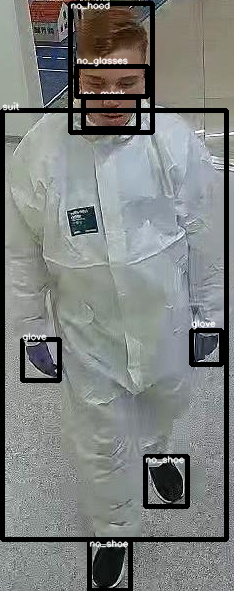

In [ ]:
show_prediction(f"/content/test/images/{os.listdir('/content/test/images')[1]}")

# Saving model

In [ ]:
model_path = model.export(format="onnx")
model_path

Ultralytics YOLOv8.0.132 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU

PyTorch: starting from runs/detect/train/weights/best.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 16, 8400) (21.4 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 246.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: export success ✅ 7.3s, saved as runs/detect/train/weights/best.onnx (42.7 MB)

Export complete (8.2s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=data.yaml 
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'runs/detect/train/weights/best.onnx'

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!zip -r /content/drive/MyDrive/BIOCAD/output_s_nw.zip /content/runs/detect/train

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 6%)
  adding: content/runs/detect/train/train_batch842.jpg (deflated 14%)
  adding: content/runs/detect/train/args.yaml (deflated 52%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: content/runs/detect/train/results.png (deflated 7%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 6%)
  adding: content/runs/detect/train/PR_curve.png (deflated 11%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 17%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 5%)
  adding: content/runs/detect/train/val_batch2_pred.jpg (deflated 5%)
  adding: content/runs/detect/train/R_curve.png (deflated 6%)
  adding: content/runs/detect/train/events.out.tfevents.1689150693.0a09f1fccdc2.172.0 (deflated 72%)
  adding: content/runs/detect/train/labels.jpg (deflated 29%)
  adding: content/runs/detect/train